<p style="font-size:200%;font-weight:bold">加密货币因子计算</p>

- 作者：丁文治
- 日期：2022年3月13日

In [1]:
import os
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from pandarallel import pandarallel

pd.set_option('display.max_columns', 500)
pandarallel.initialize(progress_bar=True, nb_workers=36)

ROOT = "/home/team_crypto/2022_crypto_return/"
WD = f"{ROOT}03_wdata/0001_teaching/"
RD = f"{ROOT}02_rdata/"

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# 日频数据

## 读入数据

In [2]:
df = pd.read_parquet(f'{WD}1102_crypto_day.pq')
df.shape
df = df.loc[df['market_caps'] >= 10 ** 6]
df.shape
df.sample(3)

(5183084, 8)

(1600069, 8)

,prices,market_caps,total_volumes,id,symbol,name,time,daily_ret
821,0.148220,7.147594e+06,9.967383e+05,daostack,gen,DAOstack,2020-08-09,-0.213715
580,0.000067,2.158422e+06,1.950000e+06,rupiah-token,idrt,Rupiah Token,2021-04-17,0.000373
1529,0.030601,2.184958e+06,2.160142e+05,iot-chain,itc,IoT Chain,2022-02-15,-0.025076


In [3]:
df.sort_values(['id', 'time'], ascending=True, inplace=True)

<AxesSubplot:>

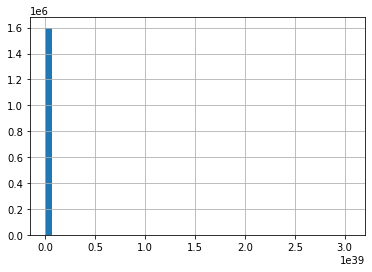

In [4]:
df['daily_ret'].hist(bins=50)

<AxesSubplot:>

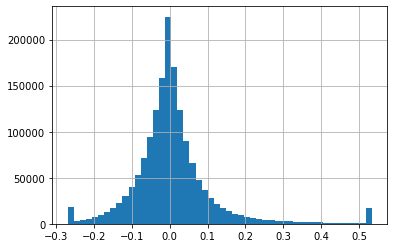

In [5]:
df.loc[df['daily_ret'] <= df['daily_ret'].quantile(0.01), 'daily_ret'] = df['daily_ret'].quantile(0.01)
df.loc[df['daily_ret'] >= df['daily_ret'].quantile(0.99), 'daily_ret'] = df['daily_ret'].quantile(0.99)
df['daily_ret'].hist(bins=50)

## 无风险利率

In [6]:
rf = pd.read_csv(f'{RD}F-F_Research_Data_Factors_daily.csv', skiprows=[0,1,2,3], names=['time', 'mkt-rf', 'smb', 'hml', 'rf'])
rf.shape
rf.dropna(how='any', inplace=True)
rf.shape
rf['time'] = pd.to_datetime(rf['time'])
rf = rf.loc[:, ['time', 'rf']]
rf['rf'] = rf['rf'].map(float) / 100
rf.sample(3)

(25170, 5)

(25168, 5)

,time,rf
18995,1997-07-22,0.00019
19373,1999-01-21,0.00019
7598,1952-04-19,0.00005


In [7]:
dates = df['time'].drop_duplicates().to_frame()
dates.shape
dates.sample(3)

(2990, 1)

,time
660,2020-05-10
94,2018-01-19
889,2020-12-25


In [8]:
rfm = dates.merge(rf, on=['time'], how='outer').set_index('time').sort_index()
rfm.isna().sum()
rfm.head(3)
rfm.tail(3)

rf    955
dtype: int64

,rf
time,
1926-07-01,0.00009
1926-07-02,0.00009
1926-07-06,0.00009


,rf
time,
2022-03-07,NaN
2022-03-08,NaN
2022-03-09,NaN


In [9]:
rfm['rf'] = rfm['rf'].interpolate()
rfm.isna().sum()

rf    0
dtype: int64

In [10]:
dfm = df.merge(rfm.reset_index(), on=['time'], how='left', indicator=True, validate='m:1')
dfm['_merge'].value_counts()
dfm.sample(3)

both          1600069
left_only           0
right_only          0
Name: _merge, dtype: int64

,prices,market_caps,total_volumes,id,symbol,name,time,daily_ret,rf,_merge
540530,9.673678,1.471364e+06,1.370124e+06,fastswap,fast,FastSwap,2021-02-27,0.010446,0.0,both
1398886,4.160856,7.401922e+07,7.104363e+05,toucan-protocol-base-carbon-tonne,bct,Toucan Protocol: Base Carbon Tonne,2022-02-21,-0.025685,0.0,both
899632,0.051827,1.263423e+08,9.656234e+06,mxc,mxc,MXC,2021-12-02,0.041190,0.0,both


In [11]:
dfm.drop(columns=['_merge']).to_parquet(f'{WD}1200_crypto_day_rf.pq')

## 市场日回报率

In [12]:
df = pd.read_parquet(f'{WD}1200_crypto_day_rf.pq')
df.shape
df.sample(3)

(1600069, 9)

,prices,market_caps,total_volumes,id,symbol,name,time,daily_ret,rf
1026998,0.168095,1.444483e+07,2793.459721,paypie,ppp,PayPie,2018-11-12,-0.038619,0.00008
92536,0.001483,1.219296e+06,102.088000,audiocoin,adc,AudioCoin,2017-09-26,0.030078,0.00005
60780,0.025915,1.303950e+06,269273.152569,anj,anj,Aragon Court,2020-07-28,-0.049047,0.00000


In [13]:
df['market_caps_l1'] = df.groupby(['id'])['market_caps'].shift()
df['wgt_ret'] = df['market_caps_l1'] * df['daily_ret']
mkt = df.groupby(['time'])[['wgt_ret', 'market_caps_l1', 'rf']].mean()
mkt['mkt_ret'] = mkt['wgt_ret'] / mkt['market_caps_l1']
mkt['cmkt'] = mkt['mkt_ret'] - mkt['rf']
mkt.sample(3)

,wgt_ret,market_caps_l1,rf,mkt_ret,cmkt
time,,,,,
2015-10-31,-8.754653e+06,1.977565e+08,0.00000,-0.044270,-0.044270
2019-03-24,1.912363e+06,2.217149e+08,0.00009,0.008625,0.008535
2022-03-07,-2.694972e+07,8.326828e+08,0.00000,-0.032365,-0.032365


In [14]:
mkt = mkt.loc[:, ['cmkt']]
mkt.reset_index(inplace=True)
mkt.sample(3)

,time,cmkt
21,2014-01-22,-0.004834
1947,2019-05-02,0.005176
1221,2017-05-06,0.046033


In [15]:
mkt['cmkt_l1'] = mkt['cmkt'].shift(1)
mkt['cmkt_l2'] = mkt['cmkt'].shift(2)

<AxesSubplot:>

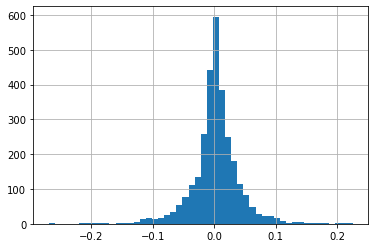

In [16]:
mkt['cmkt'].hist(bins=50)

In [17]:
mkt.to_parquet(f'{WD}1201_mkt_day.pq')

## 个股日回报率

In [18]:
mkt = pd.read_parquet(f'{WD}1201_mkt_day.pq')
mkt.shape
mkt.sample(3)

(2990, 4)

,time,cmkt,cmkt_l1,cmkt_l2
2276,2020-03-26,-0.008197,0.036500,0.093512
2597,2021-02-10,0.017744,0.148289,-0.012285
545,2015-06-30,0.020322,0.038656,-0.008969


In [19]:
df = pd.read_parquet(f'{WD}1200_crypto_day_rf.pq', columns=['id', 'time', 'daily_ret', 'rf'])
df.sort_values(['id', 'time'], ascending=True, inplace=True)
df['eret'] = df['daily_ret'] - df['rf']
df.shape
df.sample(3)

(1600069, 5)

,id,time,daily_ret,rf,eret
1475757,verge,2020-11-16,-0.018430,0.0,-0.018430
1118170,qtum,2022-01-23,-0.089850,0.0,-0.089850
324091,covesting,2020-04-12,0.041827,0.0,0.041827


In [20]:
dfm = df.merge(mkt, on=['time'], how='left', indicator=True, validate='m:1')
dfm['_merge'].value_counts()
dfm.sample(3)

both          1600069
left_only           0
right_only          0
Name: _merge, dtype: int64

,id,time,daily_ret,rf,eret,cmkt,cmkt_l1,cmkt_l2,_merge
748826,kyber-network,2019-04-10,-0.020499,0.0001,-0.020599,-0.019522,0.005088,0.027590,both
437051,doki-doki-finance,2021-08-22,-0.092100,0.0000,-0.092100,-0.008238,0.047284,0.038004,both
860285,mirrored-invesco-qqq-trust,2021-10-06,0.007088,0.0000,0.007088,0.035994,0.003278,0.012150,both


In [21]:
dfm.drop(columns=['daily_ret', 'rf', '_merge']).to_parquet(f'{WD}1202_crypto_eret_cmkt.pq')

# 读入数据

In [2]:
df = pd.read_parquet(f'{WD}1103_crypto_week.pq')
df.shape
df.sample(3)

(240380, 17)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day
185526,singulardtv,2017,40,2017-10-06,0.173592,0.173592,1.041552e+08,7.187589e+05,4.320320e+05,3.565300e+05,4.318573e+06,0.009922,0.093564,0.058796,sngls,SingularDTV,5
114654,legolas-exchange,2021,32,2021-08-13,0.526627,0.552025,8.432947e+07,4.400891e+05,1.686659e+05,1.637341e+05,8.650748e+05,0.012559,0.112805,0.084467,lgo,LGO Token,5
132031,monero,2017,52,2017-12-29,367.526988,393.149509,5.711318e+09,1.144050e+08,1.308620e+08,1.654118e+07,3.091650e+05,0.009543,0.087032,0.064854,xmr,Monero,5


In [3]:
df.sort_values(['id', 'year', 'week'], ascending=True, inplace=True)
df.duplicated(subset=['id', 'year', 'week']).sum()

0

# 计算因子

## 规模

In [4]:
df['size_mcap'] = df.groupby(['id'])['market_caps'].shift()
df['size_prc'] = df.groupby(['id'])['prices'].shift()
df['size_maxdprc'] = df.groupby(['id'])['max_prices'].shift()
df['size_age'] = df.groupby(['id'])['time'].rank().shift * 7

df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxdprc,size_age
66345,dovu,2018,5,2018-02-02,0.305166,0.407431,1.946751e+07,7.662863e+03,2.222034e+03,4.803143e+03,2.153472e+04,-0.005480,0.252395,0.161697,dov,Dovu,5,2.189672e+07,0.343384,0.493944,98.0
70487,egretia,2021,49,2021-12-10,0.001048,0.001584,4.143376e+06,1.018446e+06,5.906036e+05,5.096538e+05,7.782003e+08,-0.047951,0.057190,0.064768,egt,Egretia,5,5.851057e+06,0.001498,0.001755,1267.0
36500,cardano,2019,40,2019-10-04,0.039651,0.039651,1.233790e+09,6.918254e+07,6.525725e+07,2.189291e+07,1.779029e+09,0.006465,0.039298,0.025320,ada,Cardano,5,1.180557e+09,0.037974,0.051982,721.0


## 动量

In [5]:
for i, j in [(1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (8, 0), (16, 0), (50, 0), (100, 0)]:
    df['prc_i'] = df.groupby(['id'])['prices'].shift(i + 1)  # 注意要+1，否则就是用已有的信息去构建投资组合了，look-ahead bias
    df['prc_j'] = df.groupby(['id'])['prices'].shift(j + 1)
    df[f'mom_{i}_{j}'] = df['prc_j'] / df['prc_i'] - 1

df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxdprc,size_age,prc_i,prc_j,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0
60452,devery,2021,18,2021-05-01,0.042878,0.042878,2.697833e+06,3.227544e+04,3.227544e+04,NaN,7.527224e+05,0.318394,0.318394,NaN,eve,Devery,6,1.735067e+06,0.032523,0.032523,308.0,NaN,0.032523,0.871728,0.692982,0.478019,-0.144873,-0.543135,0.474945,0.215418,NaN,NaN
75192,equitrader,2018,38,2018-09-16,0.086815,0.086815,1.056405e+06,1.795550e+02,1.795550e+02,NaN,2.068246e+03,0.063489,0.063489,NaN,eqt,EquiTrader,7,1.065528e+06,0.087638,0.088751,203.0,NaN,0.087638,-0.164064,-0.068417,-0.233598,-0.249875,-0.102653,-0.602216,-0.505061,NaN,NaN
119290,loom-network,2020,47,2020-11-20,0.024263,0.028920,2.009153e+07,7.960598e+06,4.069466e+06,4.866324e+06,3.011267e+08,-0.020061,0.037023,0.038171,loomold,Loom Network (OLD),5,2.301981e+07,0.028086,0.034617,980.0,0.040449,0.028086,0.639495,0.558803,0.370150,0.261438,-0.230594,0.155154,0.227853,0.600219,-0.305642


In [6]:
# df.loc[df['id'] == 'dxdao']

## 交易量

In [7]:
df['volume_vol'] = df.groupby(['id'])['unit_volumes'].shift()
df['volume_vol'] = np.log(df['volume_vol'] + 1)  # 注意要+1，因为有些周交易量为0

df['volume_prcvol'] = df.groupby(['id'])['avg_volumes'].shift()
df['volume_prcvol'] = np.log(df['volume_prcvol'] + 1)

df['volume_volscaled'] = df.groupby(['id'])['avg_volumes'].shift() / df.groupby(['id'])['market_caps'].shift()
df['volume_volscaled'] = np.log(df['volume_volscaled'] + 1)

df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxdprc,size_age,prc_i,prc_j,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0,volume_vol,volume_prcvol,volume_volscaled
84061,footballstars,2021,24,2021-06-18,0.000019,0.000031,1.614197e+07,4.066386e+06,3.221656e+06,8.826289e+05,1.681769e+11,-0.038469,0.184946,0.119998,fts,FootballStars,5,2.231292e+07,0.000026,0.000035,28.0,NaN,0.000026,0.230084,-0.121433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.058562,15.485881,0.213630
78884,everlens,2022,8,2022-02-25,0.006570,0.010079,1.595962e+06,3.063717e+06,7.111791e+05,3.336723e+06,3.802455e+08,-0.048009,0.087709,0.099279,elen,Everlens,5,2.018210e+06,0.009598,0.011033,77.0,NaN,0.009598,-0.144814,-0.259214,0.065727,-0.586999,-0.517063,-0.766135,NaN,NaN,NaN,13.739476,9.149712,0.004652
14780,aurora-dao,2022,1,2022-01-07,0.223936,0.264715,1.387119e+08,8.098515e+06,6.622926e+06,2.590468e+06,3.222623e+07,-0.022369,0.014188,0.036208,idex,IDEX,5,1.622619e+08,0.263469,0.279352,1449.0,0.012984,0.263469,-0.059977,-0.059653,-0.150143,-0.267979,-0.221273,0.054950,-0.480093,6.704615,19.291729,17.861316,16.546262,0.090358


## 波动性

In [8]:
df['vol_retvol'] = df.groupby(['id'])['std_daily_ret'].shift()
df['vol_maxret'] = df.groupby(['id'])['max_daily_ret'].shift()
df['vol_stdprcvol'] = df.groupby(['id'])['std_volumes'].shift()
df['vol_damihud'] = df.groupby(['id'])['avg_daily_ret'].shift().map(abs) / df.groupby(['id'])['avg_volumes'].shift()

df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxdprc,size_age,prc_i,prc_j,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0,volume_vol,volume_prcvol,volume_volscaled,vol_retvol,vol_maxret,vol_stdprcvol,vol_damihud
87725,gastoken,2020,33,2020-08-14,159.008576,159.008576,2.917660e+06,200734.723947,204618.596486,5492.625219,1.669028e+03,0.747842,0.838791,0.128620,gst2,GasToken,5,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185685,singulardtv,2020,43,2020-10-23,0.005574,0.006219,4.960928e+06,170295.889496,140173.203879,126761.912382,3.038070e+07,-0.010529,0.061035,0.068195,sngls,SingularDTV,5,5.425789e+06,0.006093,0.006771,1484.0,0.02042,0.006093,0.015612,-0.102973,-0.098745,-0.226308,-0.238202,-0.441468,-0.501176,-0.378157,-0.701626,16.837308,11.807484,0.024442,0.052631,0.105447,59901.090526,2.508679e-08
168066,quadrant-protocol,2019,18,2019-05-03,0.003257,0.003484,1.551143e+06,523651.766260,347013.531073,160231.081024,1.782904e+08,0.080686,0.198336,0.108969,equad,Quadrant Protocol,5,1.125972e+06,0.002408,0.003729,49.0,NaN,0.002408,0.037179,0.041725,0.054011,-0.017109,-0.052342,NaN,NaN,NaN,NaN,18.951466,13.133801,0.370990,0.274783,0.650957,143604.197592,4.321806e-07


In [9]:
er = pd.read_parquet(f'{WD}1202_crypto_eret_cmkt.pq')
er.shape
er.sample(3)

(1600069, 6)

,id,time,eret,cmkt,cmkt_l1,cmkt_l2
673026,icon,2018-07-26,0.032369,-0.020280,0.067776,0.013816
58555,amoveo,2021-12-31,0.534448,0.014967,-0.028696,-0.060051
455906,eboost,2018-07-22,-0.013321,0.018728,-0.041514,-0.003389


In [10]:
df['time_l1'] = df.groupby(['id'])['time'].shift()
df['key'] = df[['id', 'time_l1']].values.tolist()
df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxdprc,size_age,prc_i,prc_j,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0,volume_vol,volume_prcvol,volume_volscaled,vol_retvol,vol_maxret,vol_stdprcvol,vol_damihud,time_l1,key
39637,chainium,2018,49,2018-12-07,0.101998,0.140323,7.831759e+06,2.273409e+05,3.346879e+05,8.831278e+04,1.836628e+06,0.001732,0.291963,0.163179,chx,WeOwn,5,7.851905e+06,0.108612,0.113496,217.0,NaN,0.108612,0.595701,0.370854,-0.071108,0.561286,-0.021567,5.247564,2.929731,NaN,NaN,14.236364,11.767170,0.016289,0.159480,0.417510,4.065353e+04,6.046631e-07,2018-11-30,"[chainium, 2018-11-30 00:00:00]"
108559,just,2020,52,2020-12-25,0.023575,0.027609,3.360949e+07,5.807225e+07,5.281891e+07,1.704836e+07,2.277346e+09,-0.012887,0.111720,0.086157,jst,JUST,5,3.786662e+07,0.026431,0.026431,238.0,NaN,0.026431,0.021511,-0.068956,0.227239,0.229401,0.203513,0.015138,-0.515581,NaN,NaN,21.034534,17.386411,0.662061,0.014808,0.018627,1.361510e+07,8.830524e-11,2020-12-18,"[just, 2020-12-18 00:00:00]"
236850,zclassic,2022,1,2022-01-07,0.115386,0.130424,1.066851e+06,1.771186e+04,5.690629e+03,8.869039e+03,1.384024e+05,-0.007098,0.064314,0.044662,zcl,Zclassic,5,1.133331e+06,0.122034,0.142266,1771.0,0.257831,0.122034,-0.138066,-0.089095,-0.126751,-0.278713,-0.163176,-0.244413,-0.147865,-0.361561,-0.52669,12.175613,10.139533,0.022098,0.047371,0.057656,8.277178e+03,7.904161e-07,2021-12-31,"[zclassic, 2021-12-31 00:00:00]"


In [11]:
df.loc[49891, ['key']].values

array([list(['crowd-machine', Timestamp('2018-06-08 00:00:00')])],
      dtype=object)

In [12]:
idx, time = df.loc[49891, ['key']].values[0]
time_l365 = time - pd.offsets.Day(365)
idx, time, time_l365

('crowd-machine',
 Timestamp('2018-06-08 00:00:00'),
 Timestamp('2017-06-08 00:00:00'))

In [13]:
def cal_vol(key):
    idx, time = key
    time_l365 = time - pd.offsets.Day(365)
    tmp = er.loc[(er['id'] == idx) & er['time'].between(time_l365, time)].dropna()
    
    if tmp.shape[0] <= 60: return np.nan, np.nan, np.nan  # 样本量太少了就不估计beta和residual了
    
    X1 = tmp[['cmkt']].values
    X2 = tmp[['cmkt', 'cmkt_l1', 'cmkt_l2']].values
    Y = tmp['eret'].values
    
    reg = LinearRegression().fit(X1, Y)
    beta = reg.coef_[0]
    idio = (Y - reg.predict(X1)).std()
    r1 = reg.score(X1, Y)
    
    reg = LinearRegression().fit(X2, Y)
    r2 = reg.score(X2, Y)
    delay = r2 - r1
    
    return beta, idio, delay

In [14]:
cal_vol(df.loc[173190, ['key']].values[0])

(1.1470472260139422, 0.05663426558748728, 0.001797864263323845)

In [19]:
%%time
df['result'] = df['key'].parallel_apply(cal_vol)  # .head()

CPU times: user 1min 23s, sys: 7.74 s, total: 1min 31s
Wall time: 12min 32s


In [21]:
df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxdprc,size_age,prc_i,prc_j,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0,volume_vol,volume_prcvol,volume_volscaled,vol_retvol,vol_maxret,vol_stdprcvol,vol_damihud,time_l1,key,result
4910,agave-token,2022,2,2022-01-14,122.524813,129.633713,3.418153e+06,6.044001e+04,4.598527e+04,4.671089e+04,4.820202e+02,-0.007301,0.060054,0.053184,agve,Agave Token,5,3.620302e+06,130.091736,150.746330,322.0,NaN,130.091736,0.016199,0.393794,0.420013,0.166852,0.148252,-0.373377,-0.289922,NaN,NaN,6.101999,11.064618,0.017488,0.067661,0.136378,4.710243e+04,6.545351e-08,2022-01-07,"[agave-token, 2022-01-07 00:00:00]","(0.8115564838141565, 0.08091106736636855, 0.01..."
224319,viberate,2021,41,2021-10-15,0.053614,0.057632,9.780105e+06,1.883569e+06,1.385427e+06,7.877615e+05,3.507427e+07,0.002284,0.135192,0.076568,vib,Viberate,5,9.644565e+06,0.053676,0.053676,1456.0,0.024876,0.053676,0.384188,0.253443,0.109365,0.036294,-0.251334,0.101973,0.113625,2.402310,1.157736,17.471336,14.417919,0.173434,0.027946,0.080993,8.755400e+05,2.620468e-08,2021-10-08,"[viberate, 2021-10-08 00:00:00]","(1.176696765604707, 0.06916296294991257, 0.011..."
42095,civic,2020,12,2020-03-20,0.018316,0.018316,1.228407e+07,5.978379e+06,9.366353e+06,1.662840e+06,3.559745e+08,0.038525,0.118303,0.082557,cvc,Civic,5,9.331079e+06,0.014346,0.032509,966.0,0.281728,0.014346,-0.559435,-0.412075,-0.522237,-0.558701,0.001666,-0.282346,-0.565081,-0.820498,-0.949078,19.232173,15.571233,0.482582,0.164844,0.022633,1.264073e+06,1.639653e-08,2020-03-13,"[civic, 2020-03-13 00:00:00]","(0.8061129778913751, 0.054827401978624436, 0.0..."


In [28]:
df['vol_beta'], df['vol_idiovol'], df['vol_delay'] = zip(*list(df['result'].values))
df['vol_beta2'] = df['vol_beta'] ** 2
df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxdprc,size_age,prc_i,prc_j,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0,volume_vol,volume_prcvol,volume_volscaled,vol_retvol,vol_maxret,vol_stdprcvol,vol_damihud,time_l1,key,result,vol_beta,vol_idiovol,delay,vol_beta2,vol_delay
162667,portal,2019,32,2019-08-09,0.004361,0.005463,2.596102e+06,206524.849648,139951.095150,78849.398474,4.160765e+07,-0.021986,0.065040,0.046915,portal,Portal,5,3.058307e+06,0.005130,0.005130,189.0,NaN,0.005130,0.137273,0.111439,0.000395,-0.136382,-0.240624,-0.196377,-0.300188,NaN,NaN,17.654677,12.299627,0.069348,0.048521,0.075796,156442.293834,8.900594e-08,2019-08-02,"[portal, 2019-08-02 00:00:00]","(0.8430068225478988, 0.13107015855793447, 0.00...",0.843007,0.131070,0.003499,0.710661,0.003499
131110,moeda-loyalty-points,2018,24,2018-06-15,0.570923,0.727063,1.120658e+07,557797.531722,482808.816303,73890.018553,9.157646e+05,-0.039000,0.067853,0.066557,mda,Moeda Loyalty Points,5,1.502032e+07,0.765215,0.789059,224.0,NaN,0.765215,0.080134,0.028007,-0.138889,-0.270243,-0.324384,-0.105856,-0.454391,NaN,NaN,14.185317,13.914948,0.070959,0.042582,0.069819,847505.563286,1.072851e-08,2018-06-08,"[moeda-loyalty-points, 2018-06-08 00:00:00]","(0.9704190320275414, 0.08050545259642072, 0.00...",0.970419,0.080505,0.005042,0.941713,0.005042
102994,indorse,2017,52,2017-12-29,0.169953,0.169953,7.904222e+06,404222.197512,338022.102041,45003.227405,2.790395e+06,0.074986,0.193461,0.101883,ind,Indorse,5,4.896331e+06,0.105279,0.121993,105.0,NaN,0.105279,0.144556,0.139632,0.245208,0.568194,0.370133,0.964761,NaN,NaN,NaN,14.965363,12.763659,0.068907,0.072136,0.102974,26803.157324,6.209098e-08,2017-12-22,"[indorse, 2017-12-22 00:00:00]","(0.4536314413810586, 0.12620018468447455, 0.01...",0.453631,0.126200,0.018436,0.205781,0.018436


## 输出

In [29]:
df2 = df.copy()
df2.drop(columns=['time_l1', 'key', 'result'], inplace=True)
df2.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxdprc,size_age,prc_i,prc_j,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0,volume_vol,volume_prcvol,volume_volscaled,vol_retvol,vol_maxret,vol_stdprcvol,vol_damihud,vol_beta,vol_idiovol,vol_beta2,vol_delay
134200,mossland,2021,1,2021-01-08,0.023059,0.023059,6.117117e+06,2.064467e+06,1.612297e+06,2.077766e+06,9.197985e+07,0.009753,0.072085,0.041173,moc,Mossland,5,5.910583e+06,0.021652,0.021652,910.0,0.034349,0.021652,0.142439,0.075900,0.171327,0.060582,-0.071651,0.341238,0.236833,0.768399,-0.36964,18.511959,14.627449,0.322849,0.042392,0.098363,2.151492e+06,8.856264e-09,0.898090,0.064105,0.806566,0.010572
150846,origo,2020,30,2020-07-24,0.017607,0.017607,2.892312e+06,1.610849e+06,2.651803e+06,4.995382e+05,9.580801e+07,0.012350,0.055783,0.021783,ogo,Origo,5,2.665524e+06,0.016179,0.017018,427.0,NaN,0.016179,0.167390,0.158211,0.276728,0.171364,0.003404,0.573190,1.052471,-0.537363,NaN,19.329694,15.217416,0.925945,0.110545,0.227917,3.009722e+06,6.693792e-09,1.093623,0.079092,1.196010,0.005067
170325,raiden-network,2019,51,2019-12-20,0.115701,0.126655,5.852627e+06,1.736437e+06,8.862503e+05,9.611751e+05,1.443962e+07,-0.006542,0.067510,0.060192,rdn,Raiden Network Token,5,6.199382e+06,0.122537,0.135403,770.0,7.195545,0.122537,0.002171,-0.086049,-0.088243,-0.248652,-0.250280,-0.238634,-0.340166,-0.447498,-0.98297,16.110553,14.047462,0.185165,0.050181,0.066703,2.298981e+05,1.111640e-09,0.971172,0.052750,0.943175,0.007049


In [30]:
df2.to_parquet(f'{WD}1203_cypto_factor.pq')

<AxesSubplot:>

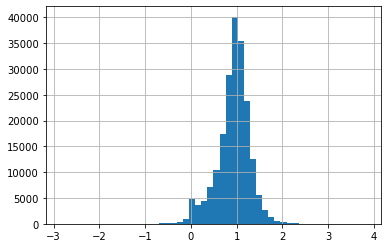

In [31]:
df2['vol_beta'].hist(bins=50)

<AxesSubplot:>

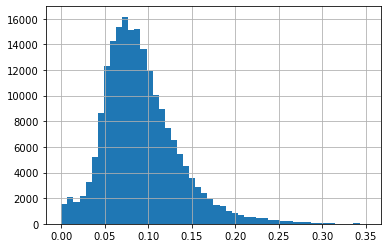

In [33]:
df2['vol_idiovol'].hist(bins=50)

<AxesSubplot:>

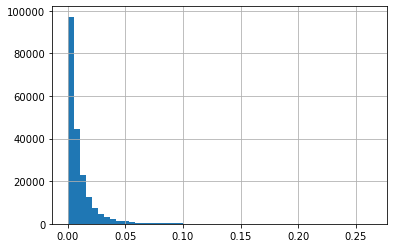

In [34]:
df2['vol_delay'].hist(bins=50)